In [27]:
#import get to call a get request on the site
from requests import get

#get the first page of the east bay housing prices
response = get('https://chicago.craigslist.org/search/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [28]:
#grab the first post
post_one = posts[0]

In [29]:
#grab the price of the first post
post_one_price = post_one.a.text
post_one_price.strip()

'$1585'

In [30]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

In [31]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text

In [32]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element

post_one_num_bedrooms = post_one.find('span', class_ = 'housing')
print(post_one_num_bedrooms)

post_one_sqft = post_one.find('span', class_ = 'housing') #cleans the ft2 at the end
print(post_one_sqft)


None
None


In [41]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = posts[0].find('span', class_='result-hood').text

import re
re.findall(r"[\w]+", testing)[0].title() #this takes only letters, thereby bypassing all the possible delimiters (,, /, -, etc.)


#post_hood = posts[100].find('span', class_= 'result-hood').text
#post_hood = re.findall(r"[\w]+", posts[100].find('span', class_= 'result-hood').text)[0].title()
#post_hood

hood = posts[28].find('span', class_= 'result-hood').text.strip().split()[0:2]

" ".join(hood).title()



SyntaxError: invalid syntax (<ipython-input-41-2c806d27b339>, line 5)

In [55]:
#build out the loop
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://chicago.craigslist.org/search/apa?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


In [57]:
import pandas as pd

eb_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
print(eb_apts.info())
eb_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2886 entries, 0 to 2885
Data columns (total 7 columns):
posted             2886 non-null object
neighborhood       2886 non-null object
post title         2886 non-null object
number bedrooms    2314 non-null object
sqft               520 non-null float64
URL                2886 non-null object
price              2886 non-null int64
dtypes: float64(1), int64(1), object(5)
memory usage: 157.9+ KB
None


posted                       neighborhood  \
0  2019-02-05 03:14                       (South Loop)   
1  2019-02-05 03:10               (Chicago - Lakeview)   
2  2019-02-05 03:06   (Wicker Park/East Humboldt Park)   
3  2019-02-05 02:59               (Chicago - Lakeview)   
4  2019-02-05 02:59                       (South Loop)   
5  2019-02-05 02:59                      (Wicker Park)   
6  2019-02-05 02:58                        (Lake View)   
7  2019-02-05 02:58                         (Lakeview)   
8  2019-02-05 02:56                       (South Loop)   
9  2019-02-05 02:55                     (Wrigleyville)   

                                                              post title  \
0                                             Charming South Loop Studio   
1     RENOVATED LAKEVIEW 1 BED ~ HWF+DW, GRANITE+SS, PETS OK, QUEEN BDRM   
2                  Smart Tech Home=Saved Money, Granite, 1 parking spot!   
3    UPDATED WRIGLEYVILLE 1 BED / 1 BATH ~ HWF, WD IN BLDG, PET FRIENDLY   
4          1 bd + 1 ba, Pet friendly building with dog run, Private park   
5  ACTUAL PHOTOS! Huge, gut rehabbed 4 Bedroom apartment in Wicker ParK!   
6      ---->Remodeled East Lakeview condo in full amenity building!<----   
7   ACTUAL PICS! Reno'd 2 BR, Near Wellington Line! Pets OK, W/D OnSite!   
8                                          Charming Studio in South Loop   
9    ACTUAL PHOTOS! HUGE Updated 2 bed/2 bath, D/W! Pets OK, W/D OnSite!   

  number bedrooms    sqft  \
0             NaN     NaN   
1               1     NaN   
2               3  1200.0   
3               1     NaN   
4               1   719.0   
5               4     NaN   
6               1     NaN   
7               2     NaN   
8             NaN     NaN   
9               2     NaN   

                                                                                                URL  \
0       https://chicago.craigslist.org/chc/apa/d/chicago-charming-south-loop-studio/6811898162.html   
1   https://chicago.craigslist.org/chc/apa/d/chicago-renovated-lakeview-1-bed-hwfdw/6811899180.html   
2     https://chicago.craigslist.org/chc/apa/d/smart-tech-homesaved-money-granite-1/6811898724.html   
3     https://chicago.craigslist.org/chc/apa/d/chicago-updated-wrigleyville-1-bed-1/6811898113.html   
4  https://chicago.craigslist.org/chc/apa/d/chicago-1-bd-1-ba-pet-friendly-building/6810148805.html   
5  https://chicago.craigslist.org/chc/apa/d/chicago-actual-photos-huge-gut-rehabbed/6811898053.html   
6    https://chicago.craigslist.org/chc/apa/d/chicago-remodeled-east-lakeview-condo/6788252268.html   
7      https://chicago.craigslist.org/chc/apa/d/chicago-actual-pics-renod-2-br-near/6811897979.html   
8    https://chicago.craigslist.org/chc/apa/d/chicago-charming-studio-in-south-loop/6811897111.html   
9     https://chicago.craigslist.org/chc/apa/d/chicago-actual-photos-huge-updated-2/6811897514.html   

   price  
0   1585  
1   1260  
2   1650  
3   1350  
4   1957  
5   3200  
6   1650  
7   1770  
8   1520  
9   1595

In [58]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many uniqe posts we really have.
eb_apts = eb_apts.drop_duplicates(subset='URL')
len(eb_apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
eb_apts['number bedrooms'] = eb_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

eb_apts['posted'] = pd.to_datetime(eb_apts['posted'])

#Looking at what neighborhoods there are with eb_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
eb_apts['neighborhood'] = eb_apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

#titlecase them
eb_apts['neighborhood'] = eb_apts['neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.split('/')[0])

#remove whitespaces
eb_apts['neighborhood'] = eb_apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data
eb_apts.to_csv("eb_apts_1642_Feb_5_19_clean.csv", index=False)

In [60]:
eb_apts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 0 to 110
Data columns (total 7 columns):
posted             111 non-null datetime64[ns]
neighborhood       111 non-null object
post title         111 non-null object
number bedrooms    89 non-null float64
sqft               20 non-null float64
URL                111 non-null object
price              111 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.9+ KB


In [61]:
import pandas as pd, numpy as np
#I think Craigslist blocked me. Reload dataframe via file for now
eb_apts = pd.read_csv("eb_apts_1642_Feb_5_19_clean.csv")

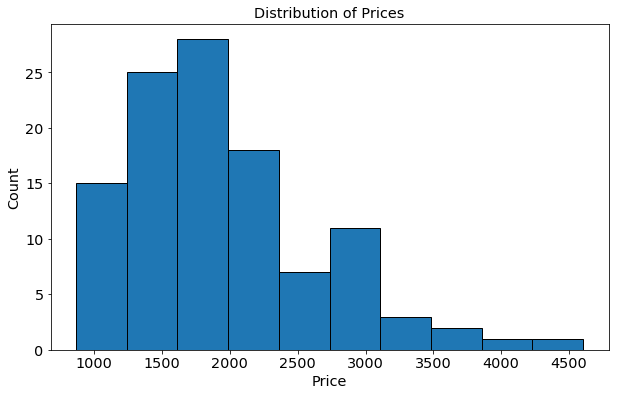

In [62]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(eb_apts['price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Prices");

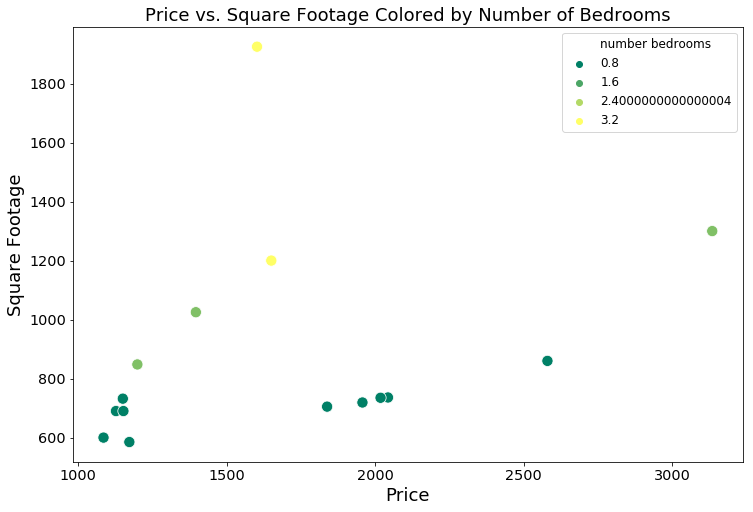

In [63]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqft', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=eb_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


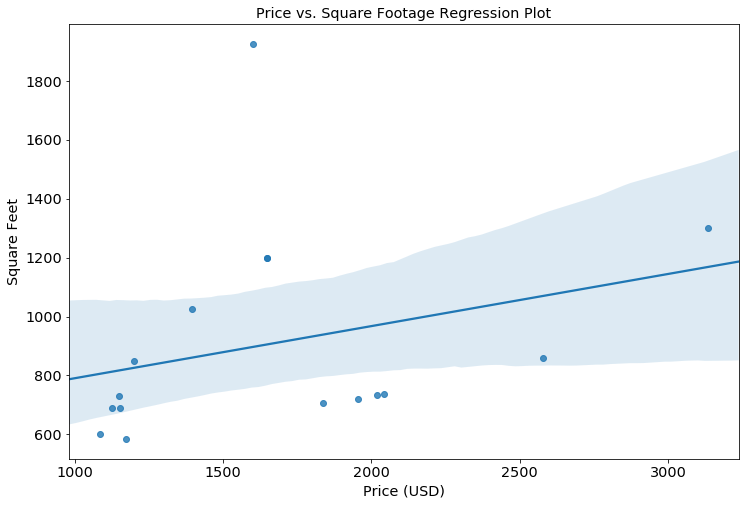

In [64]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqft', data=eb_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [65]:
eb_apts.corr()

number bedrooms      sqft     price
number bedrooms         1.000000  0.850991  0.407188
sqft                    0.850991  1.000000  0.278060
price                   0.407188  0.278060  1.000000

In [66]:
pd.options.display.max_colwidth = 100 #display full URL
cheap_chicago = eb_apts[(eb_apts['price'] < 2000)]

In [67]:
#group by neighborhood
eb_apts.groupby('neighborhood').mean()

number bedrooms  \
neighborhood                                                                     
(Arlington Heights,Mt. Prospect                                       2.000000   
(Bloomingdale                                                         1.000000   
(Buena Park                                                           1.500000   
(Chicago - Lakeview                                                   1.000000   
(Chicago - River North                                                2.000000   
(Chicago South Shore                                                  3.000000   
(Evanston                                                             1.000000   
(Fulton Market                                                        1.500000   
(Gold Coast                                                           2.000000   
(Hyde Park                                                            1.000000   
(Lake View                                                            1.500000   
(Lake View East                                                       3.000000   
(Lakeview                                                             2.000000   
(Lakeview East                                                        1.000000   
(Lincoln Park                                                         2.500000   
(Lincoln Square                                                       1.000000   
(Logan Square                                                         1.500000   
(Loop                                                                 1.333333   
(Mount Prospect                                                       1.000000   
(Mt. Prospect,Arlington Heights                                       1.000000   
(North Center                                                         2.000000   
(Old Town                                                             1.333333   
(Ravenswood                                                           1.000000   
(River North                                                          1.181818   
(River West                                                           1.500000   
(Roscoe Village                                                       2.000000   
(Schaumburg, Hoffman Estates, Hanover Park, Streamwood, Barri         2.000000   
(South Loop                                                           1.333333   
(Southloop                                                            1.000000   
(Spacious Hardwood, Great Windows, Updated Kitchen, Amazing A              NaN   
(Streeterville                                                        1.500000   
(Uptown                                                               1.500000   
(West Loop                                                                 NaN   
(Wicker Park                                                          3.000000   
(Wicker Park West                                                     3.000000   
(Wrigleyville                                                         1.750000   

                                                                 sqft  \
neighborhood                                                            
(Arlington Heights,Mt. Prospect                                 848.0   
(Bloomingdale                                                   732.0   
(Buena Park                                                       NaN   
(Chicago - Lakeview                                               NaN   
(Chicago - River North                                            NaN   
(Chicago South Shore                                           1925.0   
(Evanston                                                       705.0   
(Fulton Market                                                    NaN   
(Gold Coast                                                       NaN   
(Hyde Park                                                      585.0   
(Lake View                                                        NaN 

In [68]:
eb_apts.groupby('neighborhood').mean()['price'].sort_values()

neighborhood
(Mt. Prospect,Arlington Heights                                  1085.000000
(Mount Prospect                                                  1139.500000
(Bloomingdale                                                    1150.000000
(Lakeview East                                                   1156.000000
(Hyde Park                                                       1172.000000
(Arlington Heights,Mt. Prospect                                  1199.000000
(Ravenswood                                                      1248.750000
(Chicago - Lakeview                                              1305.000000
(Lincoln Square                                                  1350.000000
(Schaumburg, Hoffman Estates, Hanover Park, Streamwood, Barri    1396.000000
(Spacious Hardwood, Great Windows, Updated Kitchen, Amazing A    1435.000000
(North Center                                                    1491.666667
(Buena Park                                                    

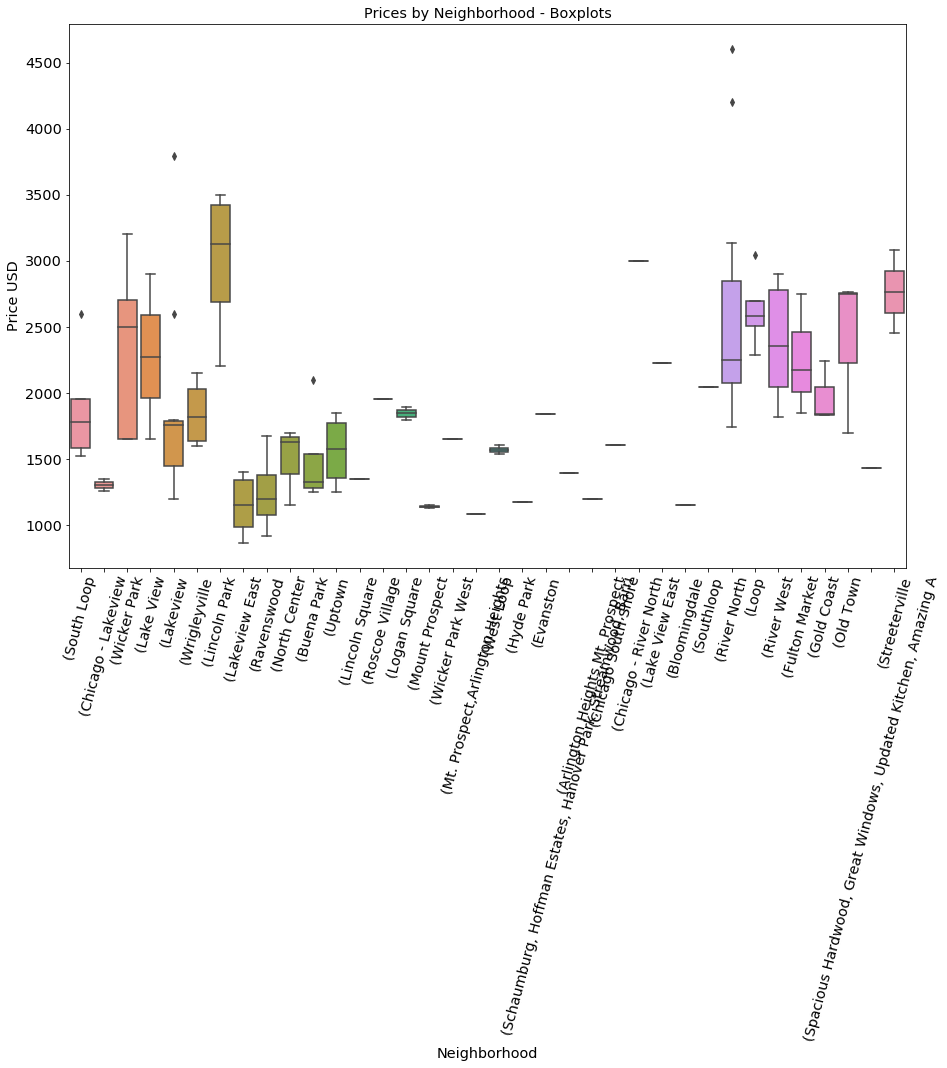

In [69]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='neighborhood', y='price', data=eb_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");